In [1]:
!pip install -q kaggle --quiet

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d wardaddy24/marble-surface-anomaly-detection-2

 98% 36.0M/36.8M [00:00<00:00, 43.6MB/s]
100% 36.8M/36.8M [00:00<00:00, 38.6MB/s]


In [11]:
!unzip marble-surface-anomaly.zip 

Archive:  marble-surface-anomaly.zip
replace dataset/test/crack/_0_0_20210531_17292_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [176]:
print(tensorflow.keras.__version__)

2.11.0


In [180]:
!pip install tensorflow==2.4.0 --quiet


ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0)
ERROR: No matching distribution found for tensorflow==2.4.0


In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow 
import keras as ks
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

In [133]:
#directories of the train and test set
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

(256, 256, 3)


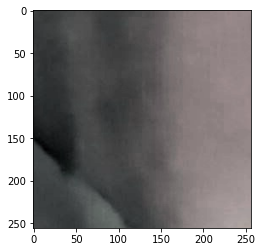

In [134]:
def get_image(path):
    img = cv2.imread(path)
    print(img.shape)
    plt.imshow(img)
image = '/content/dataset/test/crack/_0_0_20210531_17292_0.jpg'
get_image(image)

# Image Data Generator

In [135]:
def datapreprocessing(main_dir,bsize):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    train_gen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   shear_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   #validation_split=0.3,
                                   fill_mode='nearest',
                                  )

    train_generator = train_gen.flow_from_directory(
        directory=main_dir,
        target_size=(48,48),
        batch_size=bsize,
        color_mode="rgb",
        shuffle=True,
        subset="training",
        class_mode='categorical')
    
    
    
    return train_generator
    

In [136]:
traingen = datapreprocessing(train_dir,20)
validgen = datapreprocessing(test_dir,20)

Found 2249 images belonging to 4 classes.
Found 688 images belonging to 4 classes.


In [61]:
#labelnames
labelnames = traingen.class_indices
labelnames


{'crack': 0, 'dot': 1, 'good': 2, 'joint': 3}

In [137]:
#Function that can build a dataframe on passing folderpath.
def getdata(folder_path):
    sig = pd.DataFrame(columns=['image_abs_path','image_labels'])
    for key,value in labelnames.items():
        #print("processing for label: {}".format(label))
        label_i = folder_path+"/"+str(key)
        #read directory
        dirs_label_i =  os.listdir(label_i)
        idx = 0
        for image in dirs_label_i:
            #create a absolute image path
            sig_i = os.path.join(label_i,image)
            #print('Absolute path for image no. {} and label {}: {}'\
                  #.format(idx,label,flower_i))

            #fill the dataframe with path and label
            sig = sig.append({'image_abs_path':sig_i,
                            'image_labels':key},
                           ignore_index=True)
            idx += 1
    return sig

In [138]:
valid = getdata(test_dir)

In [139]:
valid.sample(5)

,image_abs_path,image_labels
43,/content/dataset/test/crack/_256_2816_20210525...,crack
302,/content/dataset/test/good/_1024_4096_20210531...,good
164,/content/dataset/test/crack/_1536_2816_2021053...,crack
525,/content/dataset/test/good/_0_1536_20210531_10...,good
613,/content/dataset/test/joint/_1792_1792_2021053...,joint


In [140]:
# Fetch n number of images from train data frame
def get_n_images(n,df,label):
    import warnings
    warnings.filterwarnings('ignore')
    train = df[df["image_labels"]==label]
    print(len(train))
    i = 0
    m = n/2
    plt.figure(figsize=(12, 6))
    for path in train['image_abs_path'][0:n]:
        plt.subplot(2,m,i+1)
        get_image(path)
        #plt.title(train['image_labels'][i])
        i += 1
    plt.tight_layout()
    plt.show()


In [142]:
def visualize_gen(train_generator):   
    #Visualising Images Processed
    plt.figure(figsize=(6, 3))
    for i in range(0, 10):
        plt.subplot(2, 5, i+1)
        for X_batch, Y_batch in train_generator:
            image = X_batch[0]        
            plt.axis("off")
            plt.imshow((image*255).astype(np.uint8))
            break
    plt.tight_layout()
    plt.show()

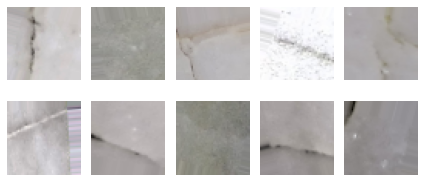

In [143]:
visualize_gen(traingen)

In [144]:
input_shape = traingen.image_shape
input_shape

(48, 48, 3)

# Build Model Architeture

In [79]:
def imageclf2(input_shape):
    from tensorflow import keras as ks
    #from tensorflow.keras import regularizers
    model = ks.models.Sequential()
    #building architecture
    #Adding layers
    model.add(ks.layers.Conv2D(8,(3,3),
                               strides=1,
                               activation="relu",
                               padding='same',
                               name="layer1",
                               input_shape=input_shape))
    model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))
    model.add(ks.layers.Dropout(0.2))
    model.add(ks.layers.Conv2D(8,(3,3),strides=1,padding="same",activation="relu",name="layer2"))
    model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))

    
    model.add(ks.layers.Flatten())
    model.add(ks.layers.Dense(128,activation="relu",
                              name="layer5"))
    model.add(ks.layers.Dropout(0.2))
    
    model.add(ks.layers.Dense(4,activation="softmax",
                              name="output"))
    model.summary()
    return model

def compiler2(model,train_generator,valid_generator,epchs,bsize=32,lr=0.0001):

    from tensorflow import keras as ks
    callbck = ks.callbacks.EarlyStopping(monitor='val_loss',patience=10,
                                         verbose=2,
                                         restore_best_weights=True,) 
    
    opt = ks.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss="categorical_crossentropy",
                      optimizer=opt,
                      metrics=["accuracy"])
    history = model.fit(train_generator,
                        epochs=epchs,
                        callbacks=[callbck],
                        validation_data=valid_generator,
                        verbose = 1,
                        #steps_per_epoch = train_generator.n // bsize
                       )
    #Visualise curves
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='valid_acc')

    plt.title('lrate='+str(lr), pad=-50)
    plt.legend()
    plt.grid(True)
    return model,history

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv2D)             (None, 48, 48, 8)         224       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 8)        0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 8)         0         
                                                                 
 layer2 (Conv2D)             (None, 24, 24, 8)         584       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 12, 8)        0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1152)             

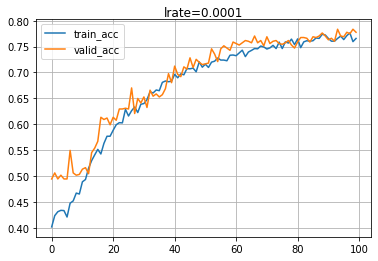

In [80]:
model01 = imageclf2(input_shape)
model_com01 = compiler2(model01,traingen,validgen,100)

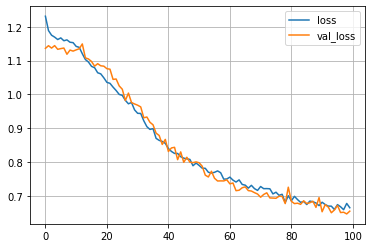

In [145]:
#Visualise loss curves
history = model_com01[1]
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [99]:
!pip install keras --quiet

In [193]:
import tensorflow.keras.preprocessing.image as kpi
@tensorflow.autograph.experimental.do_not_convert
def get_predictions(n):
    import keras as ks
    image1= validgen[0][0][n]
    #print(image1.shape)
    plt.imshow(image1)
    
    input_arr = kpi.img_to_array(validgen[0][0][n])
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    predictions = model_com01[0].predict(input_arr)
    #our dictionary starts from 1 whereas model has classes from 0.
    return predictions

1/1 [==============================] - 0s 62ms/step


array([[0.61188126, 0.12495964, 0.17473038, 0.08842872]], dtype=float32)

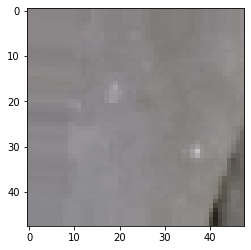

In [194]:
get_predictions(17)

In [195]:
# Fetch n number of images from train data frame
def get_n_images(n,df,label):
    import warnings
    warnings.filterwarnings('ignore')
    
    train = df[df["image_labels"]==label]
    print(len(train))
    i = 0
    m = int(n/2)
    plt.figure(figsize=(12, 6))
    for path in train['image_abs_path'][0:n]:
        plt.subplot(2,m,i+1)
        get_image(path)
        #plt.title(train['image_labels'][i])
        i += 1
    plt.tight_layout()
    plt.show()

246
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


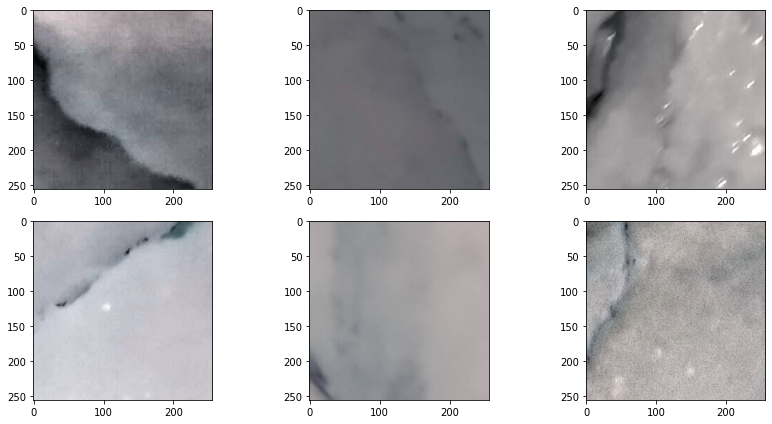

In [196]:
#Visualise Predictions for cracked
get_n_images(6,valid,"crack")

78
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


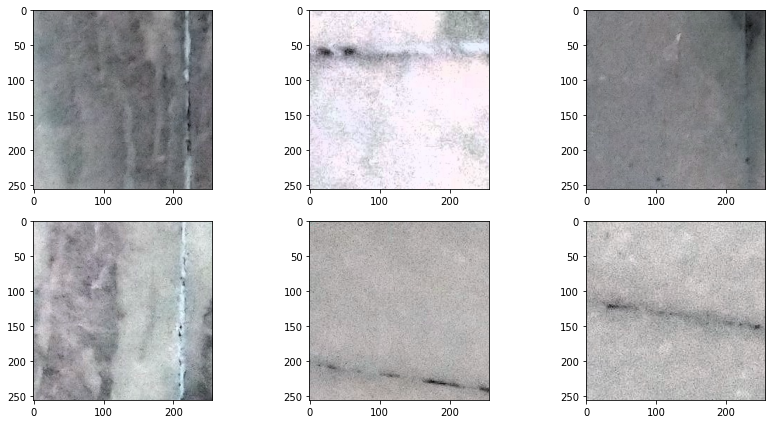

In [197]:
get_n_images(6,valid,"joint")

In [198]:
model = model_com01[0]
model.save('model.h5')